In [1]:
#hide
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../../../test_data/system_tests/proteoforms/mann_labs_egfr")

In [3]:
SAMPLEMAP_PHOSPHO = "samplemap_phospho.tsv"
SAMPLEMAP_PROTEOME = "samplemap_egfr_100ng.tsv"

CONDPAIRS = [("untreated","egf_treated")]
CONDPAIR = CONDPAIRS[0]

RESULTS_DIR_PHOSPHO = "results_phospho_nocollapse"
RESULTS_DIR_PROTEOME = "results_minrep5_median_ion"
RESULTS_DIR_PROTEOME = "results_minrep5_clustp02_fcfc0_clustermerge07_single_linkage"
RESULTS_DIR_PROTEOME = "results_minrep5_clustp02_fcfc0_clustermerge05_single_linkage"
RESULTS_DIR_PROTEOME = "results_minrep5_clustp02_fcfc0_clustermerge05"
RESULTS_DIR_PROTEOME = "results_minrep5_fewclusterfilt"
RESULTS_DIR_PROTEOME = "results_minrep5_clustp02_fcfc0_clustermerge03_single_linkage"
RESULTS_DIR_PROTEOME = "results"

INPUT_FILE_PHOSPHO = "20230803_163821_PhosphoLiDIA_Report.zip"
PEPTIDES_W_PHOSPHO_DETECTION = "peptides_w_phospho_detection.tsv"
INPUT_FILE_PROTEOME = "20230411_100022_20230330_Constantin_aQ2_Report.filtered_to_100ng.tsv"
PHOSPHO_PREDLIB = "../phospho_predlib/human_uniprot_reviewed_phos_prob.tsv"

OUTDIR_PLOTS = "outdir_plots"
OUTDIR_TABLES = "outdir_tables"

FC_THRESHOLD = 0.75


In [4]:
import alphaquant.utils.utils as aqutils

condpairtree_proteome = aqutils.read_condpair_tree(cond1=CONDPAIR[1], cond2=CONDPAIR[0], results_folder=RESULTS_DIR_PROTEOME)
condpairtree_ptm = aqutils.read_condpair_tree(cond1=CONDPAIR[0], cond2=CONDPAIR[1], results_folder=RESULTS_DIR_PHOSPHO)




In [5]:
import alphaquant.cluster.outlier_scoring as aqoutlier

ptm_loader = aqoutlier.ModifiedPeptideLoader(condpairtree_ptm, specific_modification="_[")

outlier_loader = aqoutlier.OutlierPeptideLoader(condpairtree_proteome)

complemented_clusterloader = aqoutlier.ComplementedClusterLoader(outlier_peptide_loader=outlier_loader, modified_peptide_loader=ptm_loader)

In [6]:

outlier_handler = aqoutlier.OutlierHandler(results_dir = RESULTS_DIR_PROTEOME, cond1 = CONDPAIR[0], cond2 = CONDPAIR[1])
clusterdiff_list = outlier_handler.get_diffclust_overview_list()
print(len(clusterdiff_list))

9540


# Evaluate phospho enrichment in Outlier peptides

In [7]:
import numpy as np
import pandas as pd

def get_modified_seqs_from_peptides_df(input_file_ptm):
    modified_peptides_df = pd.read_csv(input_file_ptm, sep = "\t", usecols=["PEP.StrippedSequence", "EG.PTMPositions [Phospho (STY)]"]).drop_duplicates()
    modified_peptides_df_shortened = modified_peptides_df[[x!="nan" for x in modified_peptides_df["EG.PTMPositions [Phospho (STY)]"].astype('str')]]
    modified_peptides_formatted = {f"SEQ_{x}_" for x in modified_peptides_df_shortened["PEP.StrippedSequence"]}
    return modified_peptides_formatted

#modified_peptides_all_in_dataset = get_modified_seqs_from_peptides_df(INPUT_FILE_PHOSPHO)
modified_peptides_all_in_dataset =set(pd.read_csv(PEPTIDES_W_PHOSPHO_DETECTION, sep = "\t")["sequence"].values)


In [8]:
def get_regulated_modified_seqs_from_condpairtree(condpairtree_ptm):
    regulated_ptm_sites = [x for x in condpairtree_ptm.children if x.p_val*14000  <0.01 and abs(x.fc) > FC_THRESHOLD]#and abs(x.fc) > 0.5]
    peptide_names = []
    for site in regulated_ptm_sites:
        for peptide in site.children:
            peptide_names.append(peptide.name)
    return peptide_names

modified_peptides_all_in_dataset = set(get_regulated_modified_seqs_from_condpairtree(condpairtree_ptm))
    

In [11]:
import pandas as pd

df_phospho_predlib = pd.read_csv(PHOSPHO_PREDLIB, sep='\t')
df_phospho_predlib["sequence"] = [f"SEQ_{x}_" for x in df_phospho_predlib["sequence"]]
#drop all rows with ptm_prop < 0.5
predicted_phosphoprone_sequences = set(df_phospho_predlib[df_phospho_predlib['ptm_prob'] >= 0.5]["sequence"])

SEQ2PHOSPHOPRONE_SCORE = dict(zip(df_phospho_predlib["sequence"], df_phospho_predlib["ptm_prob"]))

#def load_all_potential_phospho_peptides(phospho_predlib)

In [12]:
def get_regulation_inferred_phosphoprone_peptides(phosphoprone_seqs, clusterdiff_list):
    regulation_inferred_phosphoprone_peptides = []
    for clusterdiff in clusterdiff_list:
        cluster_is_phosphoprone = False
        for seq in clusterdiff.outlier_peptide_names:
            if seq in phosphoprone_seqs:
                cluster_is_phosphoprone = True
                break
        if cluster_is_phosphoprone:
            regulation_inferred_phosphoprone_peptides.extend(clusterdiff.outlier_peptide_names)
    return set(regulation_inferred_phosphoprone_peptides)

inferred__phosphoprone_sequences = get_regulation_inferred_phosphoprone_peptides(predicted_phosphoprone_sequences, clusterdiff_list)

In [13]:
import scipy.stats
import matplotlib.pyplot as plt

def perform_hypergeometric_test(set_size, number_of_targets_in_set, number_of_draws, number_of_successes):
	print(f"set_size: {set_size}, number_of_targets_in_set: {number_of_targets_in_set}, number_of_draws: {number_of_draws}, number_of_successes: {number_of_successes}")
	hpd = scipy.stats.hypergeom(set_size, number_of_targets_in_set, number_of_draws)
	p = hpd.pmf(number_of_successes)
	return p

def calculate_odds_ratio(set_size, number_of_targets_in_set, number_of_draws, number_of_successes):
    odds_ratio =  number_of_successes/(number_of_targets_in_set * number_of_draws/set_size)
    print(f"odds_ratio: {odds_ratio:.2f}")
    return odds_ratio


import seaborn as sns
import pandas as pd



def plot_barplot_number_peptides(number_outlier_peptides, number_regulated_phosphopeptides, number_outlier_peptides_phosphoprone, 
                                 number_regulated_phosphopeptides_phospho_prone, number_outlier_phosphopeptides_phospho_prone_cluster_extended, outdir):
    # Create DataFrame
    data = {"Group": ['outlier peptides', 'outlier peptides', 'regulated phospho peptides', 'regulated phospho peptides', 'outlier peptides'],
            "Category": ['all', 'phospho-prone', 'all', 'phospho-prone', 'phospho-prone (extended)'],
            "Count": [number_outlier_peptides, number_outlier_peptides_phosphoprone, number_regulated_phosphopeptides, number_regulated_phosphopeptides_phospho_prone, number_outlier_phosphopeptides_phospho_prone_cluster_extended]}
    df = pd.DataFrame(data)

    # Create barplot
    barplot = sns.barplot(x="Group", y="Count", hue="Category", data=df, palette="muted")

    # Show the plot
    barplot.figure.savefig(f"{outdir}/number_comparison.pdf")
    plt.show()


66306
66306
set_size: 66306, number_of_targets_in_set: 713, number_of_draws: 4269, number_of_successes: 159
odds_ratio: 3.46
5.797781399732327e-44


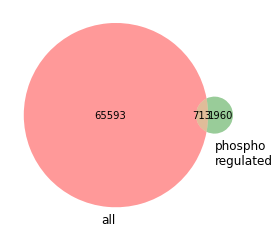

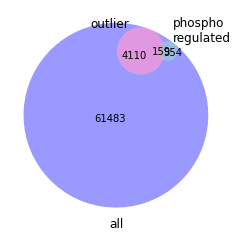

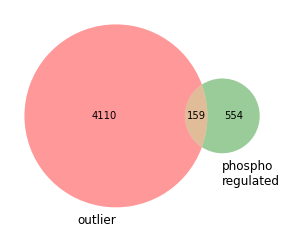

deep learning prediction


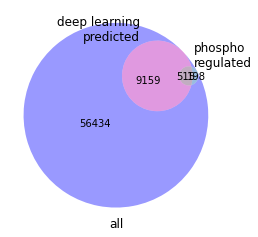

set_size: 66306, number_of_targets_in_set: 713, number_of_draws: 9674, number_of_successes: 515
7.085830277936794e-268
odds_ratio: 4.95
combined deep learning & modpep prediction


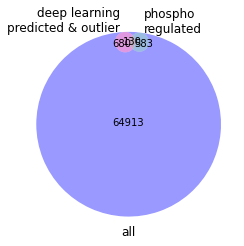

set_size: 66306, number_of_targets_in_set: 713, number_of_draws: 810, number_of_successes: 130
odds_ratio: 14.93
4.126376604549865e-111


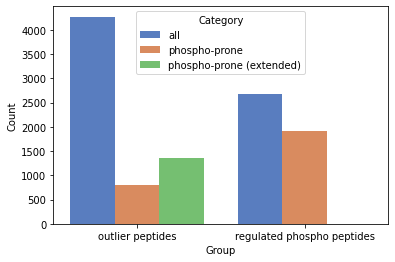

In [14]:
import pandas as pd
#outlier_filterer = aqoutlier.OutlierPeptideFilterConfigs(quality_score_quantile=1, num_mainclust_peptides_quantile=1, protnormed_fc_quantile=1)
#outlier_peps_filtered = aqoutlier.OutlierPeptideFilterer(outlier_loader.outlier_peptides, outlier_filterer.filterconfigs).get_filtered_outlier_peptide_list()
outlier_peps_filtered = [x for x in outlier_loader.outlier_peptides if abs(x.protnormed_fc) >FC_THRESHOLD]

import matplotlib_venn
import anytree
import matplotlib.pyplot as plt

outlier_peptides = {x.peptide_sequence for x in outlier_peps_filtered}
#outlier_peptides = outlier_peptides.intersection(predicted_phosphoprone_sequences)
#modified_peptides = set(ptm_loader._pepname2modpep.keys())
modified_peptides = modified_peptides_all_in_dataset


all_peptides = set([x.name for x in anytree.findall(condpairtree_proteome, filter_=lambda x : getattr(x,"type", "") == 'seq', maxlevel=3)])
print(len(all_peptides))
#all_peptides = {x for x in all_peptides if "Y" in x}
print(len(all_peptides))


M = len(all_peptides) #set size
n = len(all_peptides.intersection(modified_peptides)) #number of targets in set
N = len(outlier_peptides) #number of draws from the set
k = len(all_peptides.intersection(modified_peptides).intersection(outlier_peptides)) #number of successes
p = perform_hypergeometric_test(M, n, N, k)
calculate_odds_ratio(M, n, N, k)
print(p)


matplotlib_venn.venn2([all_peptides, modified_peptides], ["all", "phospho\nregulated"])
plt.savefig(f"{OUTDIR_PLOTS}/venn_diagrams/venn_all_peptides_modified.pdf")
plt.show()


matplotlib_venn.venn3([outlier_peptides, modified_peptides.intersection(all_peptides), all_peptides], ["outlier", "phospho\nregulated", "all"])


plt.savefig(f"{OUTDIR_PLOTS}/venn_diagrams/venn_outlier_modified_all.pdf")
plt.show()

matplotlib_venn.venn2([outlier_peptides, modified_peptides.intersection(all_peptides)], ["outlier", "phospho\nregulated"])
plt.savefig(f"{OUTDIR_PLOTS}/venn_diagrams/venn_outlier_modified.pdf")
plt.show()


print("deep learning prediction")


matplotlib_venn.venn3([predicted_phosphoprone_sequences.intersection(all_peptides), modified_peptides.intersection(all_peptides), all_peptides ], 
                      ["deep learning\npredicted", "phospho\nregulated", "all"])

plt.savefig(f"{OUTDIR_PLOTS}/venn_diagrams/venn_ptmLM.pdf")
plt.show()
p = perform_hypergeometric_test(set_size=len(all_peptides), number_of_targets_in_set=len(modified_peptides.intersection(all_peptides)),
                                number_of_draws= len(predicted_phosphoprone_sequences.intersection(all_peptides)), 
                                number_of_successes=len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(modified_peptides)))
print(p)
calculate_odds_ratio(set_size=len(all_peptides), number_of_targets_in_set=len(modified_peptides.intersection(all_peptides)),
                                number_of_draws= len(predicted_phosphoprone_sequences.intersection(all_peptides)), 
                                number_of_successes=len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(modified_peptides)))


print("combined deep learning & modpep prediction")


matplotlib_venn.venn3([predicted_phosphoprone_sequences.intersection(all_peptides).intersection(outlier_peptides), 
                       modified_peptides.intersection(all_peptides), all_peptides ], 
                      ["deep learning\npredicted & outlier", "phospho\nregulated", "all"])
plt.savefig(f"{OUTDIR_PLOTS}/venn_diagrams/venn_outlier_modified_ptmLM.pdf")
plt.show()
p = perform_hypergeometric_test(set_size=len(all_peptides), number_of_targets_in_set=len(modified_peptides.intersection(all_peptides)),
                                number_of_draws= len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(outlier_peptides)), 
                                number_of_successes=len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(modified_peptides).intersection(outlier_peptides)))

calculate_odds_ratio(set_size=len(all_peptides), number_of_targets_in_set=len(modified_peptides.intersection(all_peptides)),
                                number_of_draws= len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(outlier_peptides)), 
                                number_of_successes=len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(modified_peptides).intersection(outlier_peptides)))
print(p)


plot_barplot_number_peptides(number_outlier_peptides=len(outlier_peptides), number_regulated_phosphopeptides=len(modified_peptides), 
                             number_outlier_peptides_phosphoprone=
                             len(predicted_phosphoprone_sequences.intersection(outlier_peptides)),
                             number_regulated_phosphopeptides_phospho_prone=len(predicted_phosphoprone_sequences.intersection(modified_peptides)),
                             number_outlier_phosphopeptides_phospho_prone_cluster_extended=len(inferred__phosphoprone_sequences.intersection(outlier_peptides)),
                             outdir= OUTDIR_PLOTS)



S vs T    1.099128e-25
S vs Y    1.052524e-45
T vs Y    7.174089e-14
dtype: float64

Chi-Square value: 276.26583212126457, p-value: 1.0224375374602895e-60


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_33961/291898191.py:78: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Amino Acid', y='Occurrence', hue='Group', data=df_melted, ci=None, ax=axes[0])
/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_33961/291898191.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Amino Acid', y='Outliers', data=df, ci=None, ax=axes[1])
/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_33961/291898191.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Amino Acid', y='Phospho', data=df, ci=None, ax=axes[2])


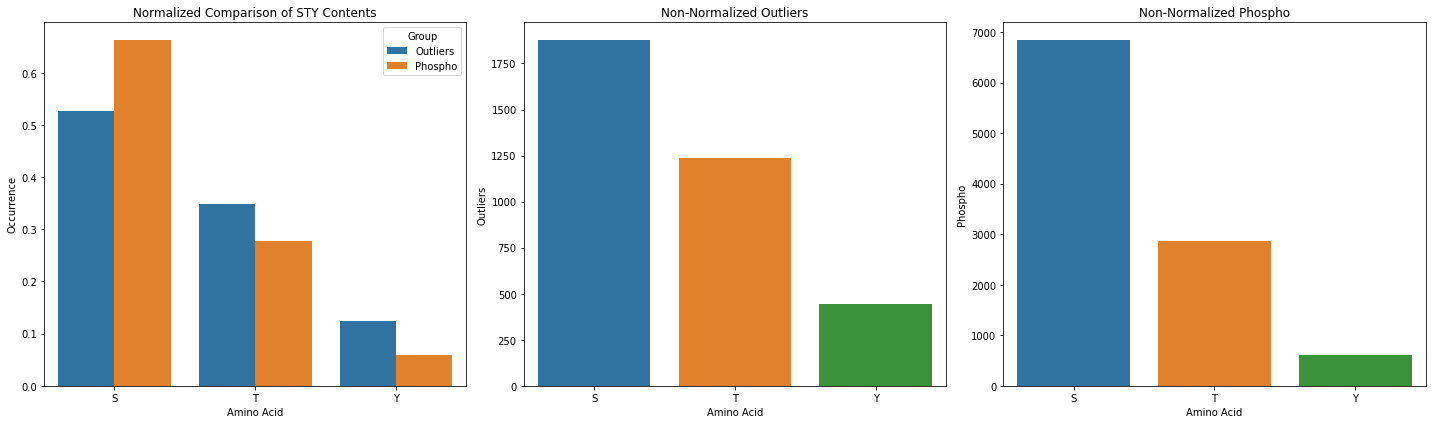

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

def count_sty_contents_peptide_groups(outlier_peptides, phospho_peptides):
    outlier_peps_reduced = remove_leading_trailing(outlier_peptides)
    phospho_peps_reduced = remove_leading_trailing(phospho_peptides)

    counts_outliers = count_sty_occurences(outlier_peps_reduced)
    counts_phospho = count_sty_occurences(phospho_peps_reduced)
    
    # Perform Chi-Square Test of Independence
    chi2, p = chi_square_test(counts_outliers, counts_phospho)
    fishers_exact_test(counts_outliers, counts_phospho)
    print(f"Chi-Square value: {chi2}, p-value: {p}")
    
    # Plot the data
    plot_data(counts_outliers, counts_phospho)

def remove_leading_trailing(seq_set):
    return {seq.lstrip("SEQ_").rstrip("_") for seq in seq_set}

def count_sty_occurences(set_of_cut_peptides):
    sty_occurences = {"S": 0, "T": 0, "Y": 0}
    for peptide in set_of_cut_peptides:
        sty_occurences["S"] += peptide.count("S")
        sty_occurences["T"] += peptide.count("T")
        sty_occurences["Y"] += peptide.count("Y")
    return sty_occurences

def chi_square_test(counts_outliers, counts_phospho):
    obs = pd.DataFrame({
        'Outliers': list(counts_outliers.values()),
        'Phospho': list(counts_phospho.values())
    }, index=list("STY"))
    chi2, p, _, _ = chi2_contingency(obs)
    return chi2, p


def fishers_exact_test(counts_outliers, counts_phospho):
    categories = list(counts_outliers.keys())
    p_values = {}
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                table = [
                    [counts_outliers[cat1], counts_outliers[cat2]],
                    [counts_phospho[cat1], counts_phospho[cat2]]
                ]
                _, p_value = fisher_exact(table)
                p_values[f"{cat1} vs {cat2}"] = p_value
    
    p_series = pd.Series(p_values)
    display(p_series)
    return p_series

def plot_data(counts_outliers, counts_phospho):
    # Prepare data for seaborn barplot
    df = pd.DataFrame({
        'Amino Acid': list(counts_outliers.keys()),
        'Outliers': list(counts_outliers.values()),
        'Phospho': list(counts_phospho.values())
    })

    df_normed = df.copy()
    df_normed['Outliers'] = df_normed['Outliers'] / df_normed['Outliers'].sum()
    df_normed['Phospho'] = df_normed['Phospho'] / df_normed['Phospho'].sum()

    # Normalize data
    
    df_melted = df_normed.melt(id_vars="Amino Acid", var_name="Group", value_name="Occurrence")
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    
    sns.barplot(x='Amino Acid', y='Occurrence', hue='Group', data=df_melted, ci=None, ax=axes[0])
    axes[0].set_title('Normalized Comparison of STY Contents')
    
    # Plot non-normalized Outliers data
    sns.barplot(x='Amino Acid', y='Outliers', data=df, ci=None, ax=axes[1])
    axes[1].set_title('Non-Normalized Outliers')
    
    # Plot non-normalized Phospho data
    sns.barplot(x='Amino Acid', y='Phospho', data=df, ci=None, ax=axes[2])
    axes[2].set_title('Non-Normalized Phospho')
    
    plt.tight_layout()
    plt.show()



set_of_outlier_peptides = inferred__phosphoprone_sequences.intersection(outlier_peptides)
set_of_phospho_peptides = modified_peptides

count_sty_contents_peptide_groups(set_of_outlier_peptides, set_of_phospho_peptides)


In [18]:
inferred_phospho_outliers = predicted_phosphoprone_sequences.intersection(outlier_peptides)
inferred_phospho_outliers = inferred__phosphoprone_sequences.intersection(outlier_peptides)


def compile_inferred_phosphoregulated_peptides_df(inferred_phospho_outliers, outlier_loader):
    # Initialize an empty list to store data
    data = []
    
    for outlier_peptide in outlier_loader.outlier_peptides:
        if outlier_peptide.peptide_sequence in inferred_phospho_outliers:
            # Append tuple (sequence, gene_name) to data
            data.append((outlier_peptide._peptide_node.parent.name, outlier_peptide.peptide_sequence, outlier_peptide.fc, outlier_peptide.protein_fc, 
                         outlier_peptide.protnormed_fc))

    # Transform the data into a pandas DataFrame
    df = pd.DataFrame(data, columns=["protein", "sequence", "log2fc_peptide", "log2fc_protein", "log2fc_protnormed"])
    
    return df

inferred_phosphoreg_df = compile_inferred_phosphoregulated_peptides_df(inferred_phospho_outliers, outlier_loader)
inferred_phosphoreg_df.to_csv(f"{OUTDIR_TABLES}/inferred_phosphoregulated_peptides.tsv", sep="\t", index=False)


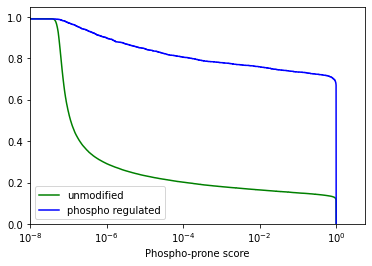

In [19]:
import numpy as np
import matplotlib.pyplot as plt

scores_outlier_peptides = [SEQ2PHOSPHOPRONE_SCORE.get(x, 1e-15) for x in outlier_peptides]
scores_modified_peptides = [SEQ2PHOSPHOPRONE_SCORE.get(x, 1e-15) for x in modified_peptides]
scores_all_peptides = [SEQ2PHOSPHOPRONE_SCORE.get(x, 1e-15) for x in all_peptides if x not in modified_peptides]

fig, ax = plt.subplots()

# Sorted data
sorted_all_peptides = np.sort(scores_all_peptides)
sorted_modified_peptides = np.sort(scores_modified_peptides)

# Calculate the inverted ECDF for the sorted data
ecdf_all_peptides = 1 - np.arange(1, len(sorted_all_peptides)+1) / len(sorted_all_peptides)
ecdf_modified_peptides = 1 - np.arange(1, len(sorted_modified_peptides)+1) / len(sorted_modified_peptides)

# Draw the histograms
ax.step(sorted_all_peptides, ecdf_all_peptides, label='unmodified', color='green')
ax.step(sorted_modified_peptides, ecdf_modified_peptides, label='phospho regulated', color='blue')

ax.legend(loc='lower left')

# Setting the x-axis to logarithmic scale
ax.set_xscale('log')

# To prevent underflow, clip minimum y-value to a small positive value.
ax.set_ylim(bottom=1e-15)
ax.set_xlim(left = 1e-8)

ax.set_xlabel('Phospho-prone score')

fig.savefig(f"{OUTDIR_PLOTS}/phosphoprone_scoredist.pdf", dpi=300)

plt.show()

## plot protein fc strengths


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_28832/2665251352.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(protein_fc, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))


<AxesSubplot:ylabel='Density'>

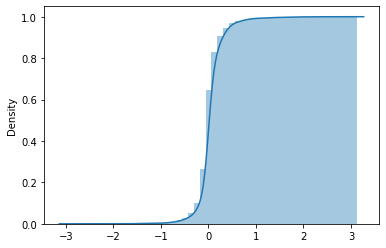

In [20]:
#histogram plot seaborn
import seaborn as sns
import matplotlib.pyplot as plt

protein_fc = [x.fc for x in condpairtree_proteome.children]

#cumulative distribution plot
sns.distplot(protein_fc, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))


pval is 0.0008752872251871947
correlation is 0.29869239965071015
92 same, 29 opposite


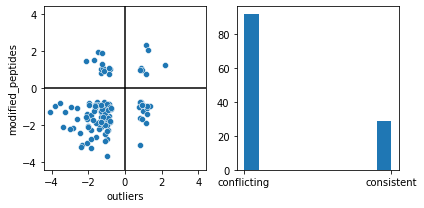

In [21]:
import matplotlib.pyplot as plt


quality_quantile = 1
filterconfigs = aqoutlier.ComplementedClusterFilterConfigs(ptm_abs_normfc_quantile=1, outlier_abs_normfc_quantile=1, outlier_quality_quantile=quality_quantile,modpep_quality_quantile=1, ptm_absfc_quantile=1,number_mainclustpeps_quantile=1).filterconfigs
complemented_clusters = aqoutlier.ComplementedClusterFilterer(complemented_clusterloader, filterconfigs).get_filtered_complemented_clusters()
complemented_clusters = [x for x in complemented_clusters if x.get_outlier_abs_normfc()>FC_THRESHOLD and x.get_ptm_abs_normfc()>FC_THRESHOLD]
complemented_clusters = [x for x in complemented_clusters if x.outlier_peptide.peptide_sequence in predicted_phosphoprone_sequences]

c_evaluator = aqoutlier.ComplementedClusterEvaluator(complemented_clusters)
corr = c_evaluator.calculate_correlation()
print(f"correlation is {corr}")

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

c_evaluator.scatter_fold_changes(axes[0])
c_evaluator.compare_regulation_directions(axes[1])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["conflicting", "consistent"])

fig.tight_layout()

fig.savefig(f"{OUTDIR_PLOTS}/compare_fc_directions.pdf")





#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
plt.show()

In [23]:
import alphaquant.viz.fcviz as aqfcviz

quantification_info = aqfcviz.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS_DIR_PROTEOME, samplemap=SAMPLEMAP_PROTEOME)
pepdf_getter = aqfcviz.ProteinIntensityDataFrameGetter(quantification_info=quantification_info)


In [24]:

quantification_info_ptms = aqfcviz.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS_DIR_PHOSPHO, samplemap=SAMPLEMAP_PHOSPHO)
pepdf_getter_ptm = aqfcviz.ProteinIntensityDataFrameGetter(quantification_info=quantification_info_ptms)


SEQ_TSLPLSPVK_
Q86XL3
outlier fc -1.1344704240546193
modified fc -1.0544457031600654


outlier protnormed -1.1272465807536018
modified protnormed -1.047221859859048
False


AttributeError: 'ProteinIntensityDataFrameGetter' object has no attribute 'get_melted_ion_intensity_table_peptide_subset'

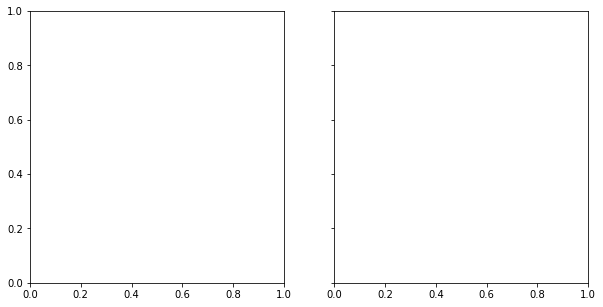

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

def plot_complemented_cluster_condpairinfo(complemented_cluster,clusterdiff_list):
    fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, sharex=False,figsize=(10,5))

    plot_peptides_of_protein(complemented_cluster,clusterdiff_list, ax1)
    plot_phospho_peptides(complemented_cluster, ax2)
    plt.subplots_adjust(bottom = 0.2)
    ax1.grid(True)
    ax2.grid(True)
    return fig



def plot_peptides_of_protein(complemented_cluster, clusterdiff_list, ax):
    condpairinfo_to_plot  = filter_relevant_condpairinfo_for_complemented_cluster(clusterdiff_list, complemented_cluster)
    peptides_to_plot = condpairinfo_to_plot.mainclust_peptide_names + [complemented_cluster.outlier_peptide.peptide_sequence]
    melted_plot_df = pepdf_getter.get_melted_ion_intensity_table_peptide_subset(protein=condpairinfo_to_plot.protein_name,peptides_to_plot=peptides_to_plot, specified_level="seq")
    fcplotter = aqfcviz.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = CONDPAIR)
    ax_protein = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_protein


def plot_phospho_peptides(complemented_cluster, ax):
    peptides_to_plot =  [complemented_cluster.modified_peptide.modified_sequence]
    melted_plot_df = pepdf_getter_ptm.get_melted_ion_intensity_table_peptide_subset(protein=complemented_cluster.modified_peptide.protein_name,peptides_to_plot=peptides_to_plot, specified_level="mod_seq")
    fcplotter = aqfcviz.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = CONDPAIR)
    ax_ptm = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_ptm


def filter_relevant_condpairinfo_for_complemented_cluster(clusterdiff_list, complemented_cluster):
    return filter(lambda x : complemented_cluster.outlier_peptide.peptide_sequence in x.outlier_peptide_names ,clusterdiff_list).__next__()




def check_if_protein_name_contains(protein_nam, list_of_proteins):
    return any(protein_nam in x for x in list_of_proteins)

list_of_interesting_proteins = ["A0A0G2JNZ2", "Q53EL6", "Q9C0C2", "P02545", "A0A0C4DGG9", "Q8N7H5-3", "A0A087WV66", "Q96RS6", "P12956", "P54760"]
#filtered_clusters = [x for x in complemented_clusters if check_if_protein_name_contains(x.outlier_peptide._peptide_node.parent.name, list_of_interesting_proteins)]
filtered_clusters = [x for x in complemented_clusters if not x.has_opposite_regulation()]

count = 0
for clust in filtered_clusters:
    protnode = clust.outlier_peptide._peptide_node.parent
    print(clust.outlier_peptide.peptide_sequence)
    print(clust.outlier_peptide._peptide_node.parent.name)
    print(f"outlier fc {clust.outlier_peptide.fc}")
    print(f"modified fc {clust.modified_peptide.fc}")
    print("\n")
    print(f"outlier protnormed {clust.outlier_peptide.protnormed_fc}")
    print(f"modified protnormed {clust.modified_peptide.protnormed_fc}")
    print(np.sign(clust.outlier_peptide.protnormed_fc) == -np.sign(clust.modified_peptide.protnormed_fc))
    fig = plot_complemented_cluster_condpairinfo(clust, clusterdiff_list)
    #fig.show()
    plt.show()
    
    pcplotter = aqfcviz.ProteinClusterPlotter(protnode,CONDPAIR, pepdf_getter)
    count+=1
    



In [20]:
import pandas as pd
interesting_cluster_proteins = set(pd.read_csv("proteins_w_interesting_clusters.tsv", sep = "\t", header = None)[0].values)
df_100ng = pd.read_csv("20230411_100022_20230330_Constantin_aQ2_Report.filtered_to_100ng.tsv", sep = "\t")





In [21]:
display(df_100ng)
df_100ng_subset = df_100ng[df_100ng["PG.ProteinGroups"].isin(interesting_cluster_proteins)]
display(df_100ng_subset)
df_100ng_subset.to_csv("../cluster_tests/100ng_subset.tsv", sep = "\t", index = False)

,R.FileName,R.Label,PG.Genes,PG.Organisms,PG.ProteinGroups,PG.Quantity,PEP.NrOfMissedCleavages,PEP.MS1ChannelQuantities,PEP.MS2ChannelQuantities,PEP.StrippedSequence,...,F.PeakHeight,F.CalibratedMassAccuracy (PPM),F.HasChannelInterference,F.InterferenceScore,F.Log10SignalToNoise,F.Noise,F.PossibleInterference,F.PPMTolerance,F.RawMassAccuracy (PPM),F.Tolerance
0,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SERPINB6,Homo sapiens,A0A024QZX5;A0A087X1N8;P35237,445048.406250,0,NaN,NaN,IAELLSPGSVDPLTR,...,3.961976e+06,0.210126,False,0.000000,2.314314,NaN,False,11.370174,3.306188,0.010705
1,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SERPINB6,Homo sapiens,A0A024QZX5;A0A087X1N8;P35237,445048.406250,0,NaN,NaN,IAELLSPGSVDPLTR,...,2.812304e+06,1.763184,False,0.014920,2.240281,NaN,False,14.142968,4.581056,0.006878
2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SERPINB6,Homo sapiens,A0A024QZX5;A0A087X1N8;P35237,445048.406250,0,NaN,NaN,IAELLSPGSVDPLTR,...,3.011028e+06,-0.450437,False,0.082038,2.128606,NaN,False,11.855213,3.085769,0.012194
3,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SERPINB6,Homo sapiens,A0A024QZX5;A0A087X1N8;P35237,445048.406250,0,NaN,NaN,IAELLSPGSVDPLTR,...,2.626228e+06,1.577546,False,0.666667,2.397201,NaN,False,10.349361,4.856841,0.003251
4,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SERPINB6,Homo sapiens,A0A024QZX5;A0A087X1N8;P35237,445048.406250,0,NaN,NaN,IAELLSPGSVDPLTR,...,1.169095e+06,0.606573,False,0.392199,1.270610,NaN,False,13.316259,3.714207,0.005689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7725734,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SAP18,Homo sapiens,X6RAL5,115322.484375,1,NaN,NaN,KGTDDSMTLQSQK,...,8.726216e-01,NaN,False,0.291267,-5.419224,NaN,False,13.262922,NaN,0.006502
7725735,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SAP18,Homo sapiens,X6RAL5,115322.484375,1,NaN,NaN,KGTDDSMTLQSQK,...,8.197030e-01,NaN,False,0.130260,0.170221,NaN,False,12.739284,NaN,0.007698
7725736,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SAP18,Homo sapiens,X6RAL5,115322.484375,1,NaN,NaN,KGTDDSMTLQSQK,...,6.815866e-01,NaN,False,0.750819,-0.261093,NaN,True,12.743754,NaN,0.007689
7725737,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SAP18,Homo sapiens,X6RAL5,115322.484375,1,NaN,NaN,KGTDDSMTLQSQK,...,7.421793e-01,NaN,False,0.454722,0.078828,NaN,True,12.338583,NaN,0.008691


,R.FileName,R.Label,PG.Genes,PG.Organisms,PG.ProteinGroups,PG.Quantity,PEP.NrOfMissedCleavages,PEP.MS1ChannelQuantities,PEP.MS2ChannelQuantities,PEP.StrippedSequence,...,F.PeakHeight,F.CalibratedMassAccuracy (PPM),F.HasChannelInterference,F.InterferenceScore,F.Log10SignalToNoise,F.Noise,F.PossibleInterference,F.PPMTolerance,F.RawMassAccuracy (PPM),F.Tolerance
3451,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,UHRF1,Homo sapiens,A0A087WTW0;A0A087WVR3;Q96T88;Q96T88-2,104068.570312,0,NaN,NaN,YAPAEGNR,...,358957.375000,-0.138127,False,0.000000,5.873472,NaN,False,14.278976,3.798894,0.007800
3452,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,UHRF1,Homo sapiens,A0A087WTW0;A0A087WVR3;Q96T88;Q96T88-2,104068.570312,0,NaN,NaN,YAPAEGNR,...,412388.406250,0.359776,False,0.000366,0.962517,NaN,False,14.447747,3.795035,0.009294
3453,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,UHRF1,Homo sapiens,A0A087WTW0;A0A087WVR3;Q96T88;Q96T88-2,104068.570312,0,NaN,NaN,YAPAEGNR,...,226333.437500,0.924042,False,0.015861,0.749767,NaN,False,14.082086,4.880491,0.006692
3454,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,UHRF1,Homo sapiens,A0A087WTW0;A0A087WVR3;Q96T88;Q96T88-2,104068.570312,0,NaN,NaN,YAPAEGNR,...,93873.078125,5.389687,False,0.666667,0.195714,NaN,True,11.272249,9.785136,0.003902
3455,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,UHRF1,Homo sapiens,A0A087WTW0;A0A087WVR3;Q96T88;Q96T88-2,104068.570312,0,NaN,NaN,YAPAEGNR,...,555199.562500,0.098970,False,0.015861,1.571953,NaN,False,10.559976,4.831106,0.003402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7615104,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,NUCKS1,Homo sapiens,Q9H1E3,36110.726562,0,NaN,NaN,VVDYSQFQESDDADEDYGR,...,0.699875,-12.342808,False,0.000000,0.181787,NaN,False,12.384704,-7.321225,0.010222
7615105,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,NUCKS1,Homo sapiens,Q9H1E3,36110.726562,0,NaN,NaN,VVDYSQFQESDDADEDYGR,...,0.531865,NaN,False,0.165243,-0.048341,NaN,False,12.197536,NaN,0.009201
7615106,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,NUCKS1,Homo sapiens,Q9H1E3,36110.726562,0,NaN,NaN,VVDYSQFQESDDADEDYGR,...,0.710099,NaN,False,0.028266,0.341400,NaN,False,11.623334,NaN,0.013279
7615107,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,NUCKS1,Homo sapiens,Q9H1E3,36110.726562,0,NaN,NaN,VVDYSQFQESDDADEDYGR,...,0.534364,NaN,False,0.238267,0.100992,NaN,False,12.577175,NaN,0.008040


In [22]:
outlier_handler = aqoutlier.OutlierHandler(results_dir = results_dir, cond1 = condpair[0], cond2 = condpair[1])
diffcluster_list = outlier_handler.get_diffclust_overview_list()

NameError: name 'results_dir' is not defined

In [ ]:
import alphaquant.outlier_scoring as aqoutlier

dcfilt = aqoutlier.DiffClusterFilterer(clusterdiff_list, aqoutlier.DiffClusterFilterConfig(fcdiff_quantile=0.001, quality_score_quantile=1, num_mainclust_peptides_quantile=1).filterconfigs)


filtlist = dcfilt.get_filtered_clusterdiff_list()
print(len(filtlist))


4


(array([6.2000e+01, 3.8900e+02, 6.4000e+01, 2.2000e+01, 1.7000e+01,
        3.0000e+00, 3.3600e+02, 6.1254e+04, 0.0000e+00, 1.0000e+00]),
 array([-0.29464298, -0.08803172,  0.11857953,  0.32519079,  0.53180205,
         0.7384133 ,  0.94502456,  1.15163582,  1.35824707,  1.56485833,
         1.77146959]),
 <BarContainer object of 10 artists>)

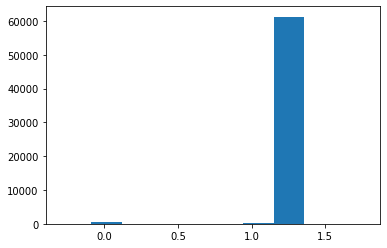

In [ ]:
all_peptides = anytree.findall(condpairtree_proteome, filter_= lambda x : getattr(x, 'type', '')== 'mod_seq_charge', maxlevel=5)
all_predscore = [x.predscore for x in all_peptides]

plt.hist(all_predscore)


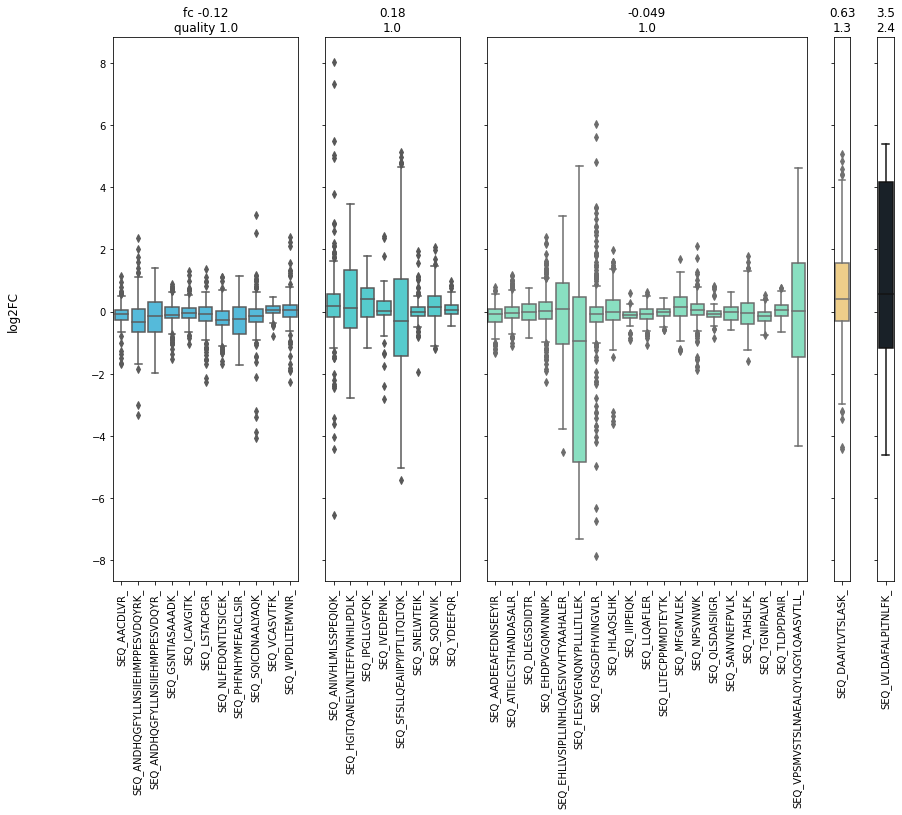

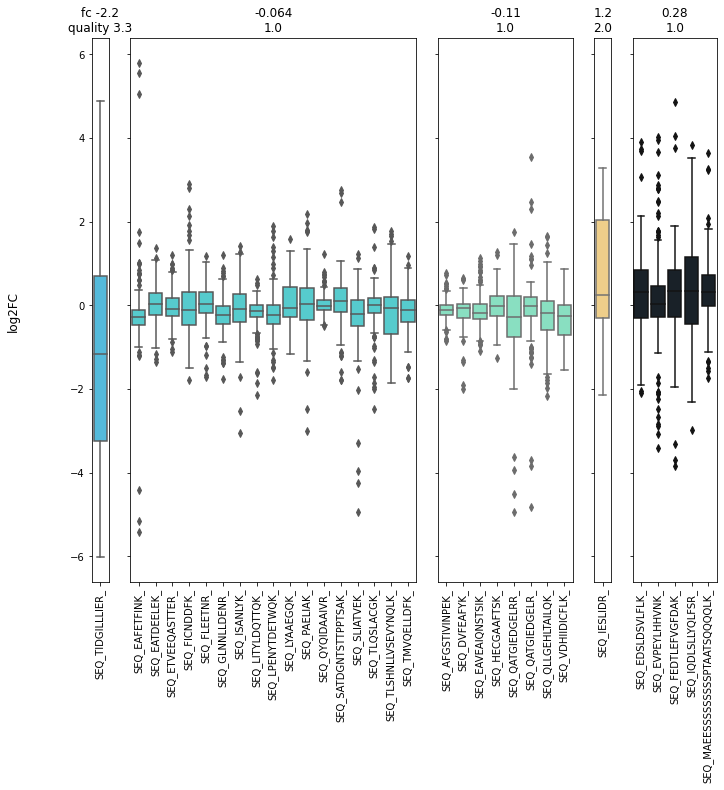

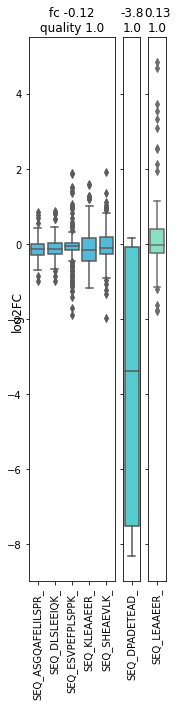

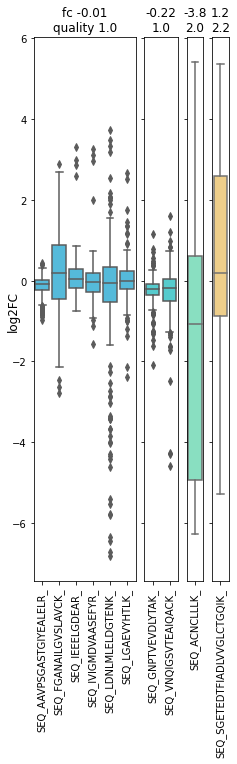

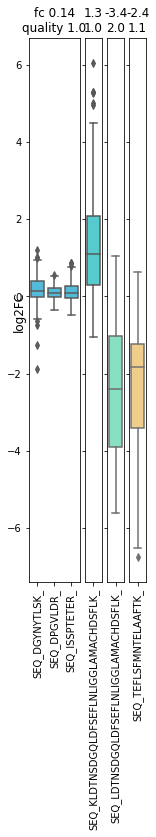

In [ ]:


for protnode in aqoutlier.ProtNodeRetriever.get_protnodes_from_clusterdiff_list(condpairtree_proteome, filtlist):
    pcplotter = ProteinClusterPlotter(protnode,condpair, pepdf_getter)
    pcplotter.plot_all_clusters_for_protein()